## What are we looking to accomplish?

What we want to do is forecast the arrival time of a line's vehicle across all it's stops given a start time at the departure stop. We will also test the accuracy of our forecasting by splitting our dataset into training and testing subsets.

From the first assignment we have a dataset that details the average time it takes for a vehicle to go from stop to stop at every hour of the day. We have 16 tables from 06/09/2021 till 21/09/2021. The travel time in this dataset includes the time a vehicle is waiting at each stop, so we will not need to account for any additional time if we use this dataset to build our prediction model.

 > #### The most significant challenge in predictions was to find a way to build a model that can be quickly deployed for any line at any time with a high accuracy.

To accomplish this, a SARIMA (Seasonal Auto Regressive Integrate Moving Average) time-series model was employed. This allows us to account for the seasonality of the data and predict the next data points behaviour based on the previous data point(s) as well as the data points from the previous seasonal cycle.

With this approach, an individual SARIMA will be created for each pair of stops, on each line, at each hour. This will result in approximately [170 lines * 4700 stops * 24 lines] 19M SARIMA functions. The function will predict the future time between stops. We can precalculate each of these predictions and save them in a lookup table for fast retrieval when needed. This way, we do not need to recompute the model every time it is called.

Technically, this approach gives us an accurate prediction for the *day following* the training data, however given the consistency of the STIB network, the model can be used for any day. An improvement to this approach would be to generate SARIMA predictions for different days of the week, and different months of the year. With access to 365 days worth of data, the model can be employed to predict today's time based on yesterday, last week, and last year, which would account for seasonality on a year-to-year basis.

So... let's get started. We will (as usual) import our needed libraries and files and complete some data manipulation to get our data into the desired format.

In [1]:
import pandas as pd
import json
import csv
import os
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
import math
import numpy as np

In [6]:
days = os.listdir('./processed_data/daily_average_time_between_stops_filtered/')
days = [x[:-4] for x in days]
average_times_per_day = []
for path in days:
    average_times_per_day.append(pd.read_csv(r'./processed_data/daily_average_time_between_stops_filtered/'+path+'.csv'))

Let's visualize one of those tables:

In [4]:
average_times_per_day[1]

,LineId,FromStop,ToStop,0,1,2,3,4,5,6,...,14,15,16,17,18,19,20,21,22,23
0,1,8733,8742,0.0,0.0,0,0,0.0,0.0,64.0,...,416.00,383.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,1,8742,8292,90.0,0.0,0,0,0.0,93.0,101.6,...,96.00,95.83,96.60,105.67,103.50,89.67,99.60,99.00,93.67,124.00
2,1,8292,8282,90.0,0.0,0,0,0.0,60.0,69.6,...,62.50,67.17,63.50,219.17,218.33,78.83,57.00,62.17,67.50,78.50
3,1,8282,8272,91.0,0.0,0,0,0.0,95.0,118.4,...,105.67,108.40,101.00,94.80,108.80,99.33,103.67,93.50,88.17,83.33
4,1,8272,8012,61.0,0.0,0,0,0.0,64.0,69.0,...,79.83,63.40,85.50,63.40,69.40,62.20,58.17,73.50,71.67,72.33
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3326,98,2610,9686,0.0,0.0,0,0,0.0,94.0,110.0,...,127.00,134.00,30.50,85.00,78.50,97.00,63.00,46.50,0.00,0.00
3327,98,9686,5964,0.0,0.0,0,0,0.0,128.0,94.5,...,129.00,125.75,168.50,120.00,113.00,109.00,127.00,92.50,0.00,0.00
3328,98,5964,3815,0.0,0.0,0,0,0.0,61.0,61.0,...,83.33,64.00,64.33,52.00,95.00,79.00,30.00,64.00,0.00,0.00
3329,98,3815,3851,0.0,0.0,0,0,0.0,0.0,62.0,...,62.67,48.50,52.67,52.00,30.00,30.00,31.00,94.00,0.00,0.00


Let's take one segment to analyze:

In [7]:
# segment departure stop
from_stop = 8282

# segment arrival stop
to_stop = 8272

Create the time series for that segment joining all days' hours:

In [8]:
# Time series list:
time_series_of_segment = []

# Populate the time series list_
for day in average_times_per_day:
    for hour in range(24):
        time_series_of_segment.append(day[(day['FromStop']==from_stop) & (day['ToStop']==to_stop)][str(hour)].values[0])

# Create the labels for every element of time series:
date_and_time = []
for day in days:
    for hour in range(24):
        date_and_time.append(day + '_' + str(hour))

# Create a table with showing the dates and hours and the corresponding average time between stops:
time_series_of_segment_df = pd.DataFrame(data={'date & hour': date_and_time, 'time': time_series_of_segment })
time_series_of_segment_df


,date & hour,time
0,2021-09-06_0,0.0
1,2021-09-06_1,0.0
2,2021-09-06_2,0.0
3,2021-09-06_3,0.0
4,2021-09-06_4,0.0
...,...,...
379,2021-09-21_19,0.0
380,2021-09-21_20,0.0
381,2021-09-21_21,0.0
382,2021-09-21_22,0.0


The goal is to create a model that, based on this table, predicts new values. Let's analyze how the time series is behaving.


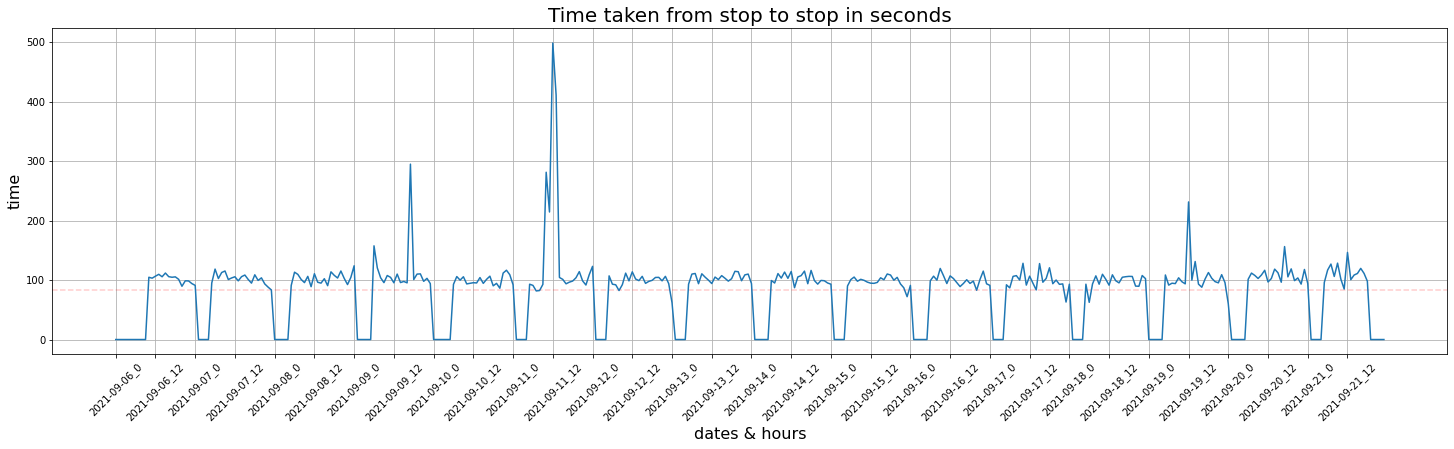

In [9]:
#----------------------------------------------------------------
# GRAPH
#----------------------------------------------------------------

# size:
plt.figure(figsize=(25,6))

# title:
plt.title('Time taken from stop to stop in seconds', fontsize=20)

# x axis:
# x values
x = []
for index in range(time_series_of_segment_df.index.stop):
    x.append(index)
# x ticks
my_xticks = time_series_of_segment_df['date & hour']
plt.xticks(x[::12], my_xticks[::12], rotation='45')
# # x label
plt.xlabel("dates & hours", fontsize=16)

# y axis:
# y values
y = time_series_of_segment_df['time']
# y label
plt.ylabel("time", fontsize=16)

# mean
plt.axhline(time_series_of_segment_df['time'].mean(), color='r', alpha=0.2, linestyle='--')

# create plot
plt.plot(x, y)
# add grids to plot
plt.grid()
# show plot
plt.show()

#----------------------------------------------------------------

From the above graph we can determine that the time series does not have a trend but there is a seasonality every 24 hours as expected. We will plot the Auto Correlation Function (ACF) and the Partional Auto Correlation Function to help determine appropriate values to use in our SARIMA model.

We will also define the size of our training and testing sets. We will take the first 90% of data to train and remaining 10% to test. We will then fit a SARIMA model and test the accuracy of the predictions with the testing data.

### Auto Correlation Function (ACF)

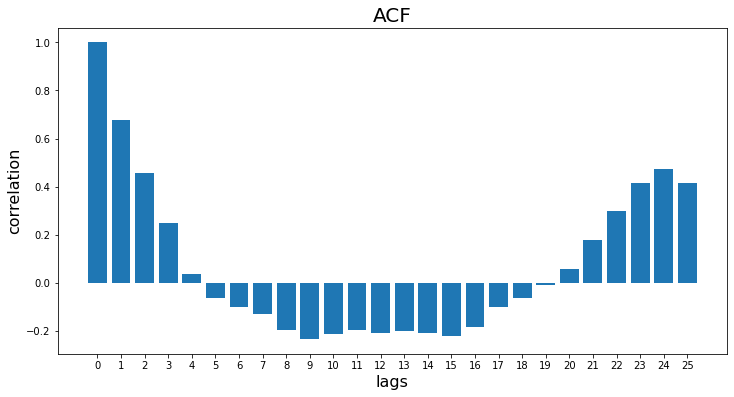

In [21]:
acf_vals = acf(time_series_of_segment_df['time'])

#----------------------------------------------------------------
# GRAPH
#----------------------------------------------------------------

# size:
plt.figure(figsize=(12,6))

# title:
plt.title('ACF', fontsize=20)

# x axis:
# x values
x = []
for index in range(len(acf_vals)):
    x.append(index)
# x ticks
my_xticks = x
plt.xticks(x, x, rotation='horizontal')
# # x label
plt.xlabel("lags", fontsize=16)

# y axis:
# y values
y = acf_vals
# y label
plt.ylabel("correlation", fontsize=16)

# create plot
plt.bar(x, y)

# show plot
plt.show()

#----------------------------------------------------------------


### Partial Auto Correlation Function (PACF)

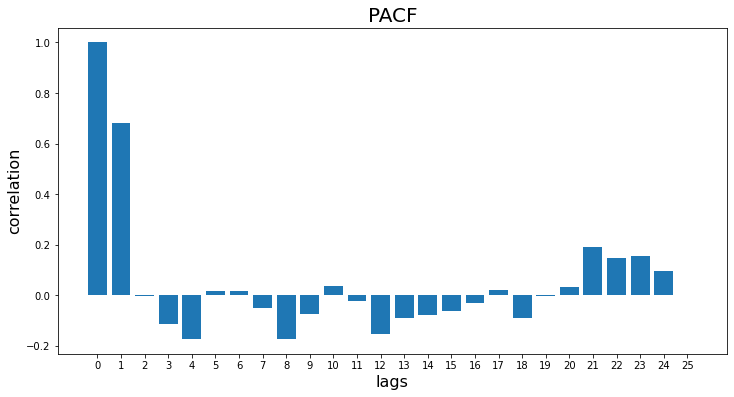

In [22]:
pacf_vals = pacf(time_series_of_segment_df['time'])

#----------------------------------------------------------------
# GRAPH
#----------------------------------------------------------------

# size:
plt.figure(figsize=(12,6))

# title:
plt.title('PACF', fontsize=20)

# x axis:
# x values
x = []
for index in range(len(pacf_vals)):
    x.append(index)
# x ticks
my_xticks = x
plt.xticks(x, x, rotation='horizontal')
# # x label
plt.xlabel("lags", fontsize=16)

# y axis:
# y values
y = pacf_vals
# y label
plt.ylabel("correlation", fontsize=16)

# create plot
plt.bar(x, y)

# show plot
plt.show()

#----------------------------------------------------------------


In [ ]:
# Percentage of data to train with:
training_percentage = 0.9

# Total number of elements:
total_number_of_elements = len(time_series_of_segment_df['time'])

# Total number of elements to train with:
number_of_elements_to_train = round(training_percentage*(total_number_of_elements))

# Training data
train_data = list(time_series_of_segment_df['time'])[:-(total_number_of_elements-number_of_elements_to_train)]

# Testing data
test_data = list(time_series_of_segment_df['time'])[number_of_elements_to_train:]

In [59]:
non_seasonal_order = (1, 0, 1)
seasonal_order = (1, 0, 1, 24)

model_fit = SARIMAX(train_data, order=non_seasonal_order, seasonal_order=seasonal_order).fit()

pred_start_date = len(train_data)
pred_end_date = len(test_data) + len(train_data)-1

predictions = model_fit.predict(start=pred_start_date, end=pred_end_date)


Text(0, 0.5, 'time from stop to stop')

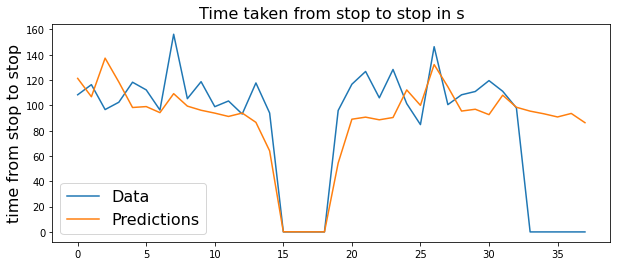

In [62]:
plt.figure(figsize=(10,4))

plt.plot(test_data)
plt.plot(predictions)

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('Time taken from stop to stop in s', fontsize=16)
plt.ylabel('time from stop to stop', fontsize=16)

Now, let's apply this aproach to make predictions for all the segments of a line for a specific numbers of days:

In [47]:
# INPUT 1: line number
line = 1

Check if the available tables the same number of segments for the given line:

In [48]:
def all_days_have_same_segments(line):

    count_segments_per_day = []

    for day_data in average_times_per_day:
        
        day_data = day_data[day_data['LineId']==line]
        
        from_stop_list = day_data['FromStop'].tolist()
        to_stop_list = day_data['ToStop'].tolist()

        segments = []

        for i in range(len(from_stop_list)):
            segment = []
            segment.append(from_stop_list[i])
            segment.append(to_stop_list[i])

            segments.append(segment)

        count_segments_per_day.append(len(segments))

    if len(set(count_segments_per_day)) == 1:
        print('The data is complete, all the tables have the same segments for line: '+str(line))
    else:
        print('The data is incomplete,some tables have different quantity of segments for line: '+str(line))

    # return count_segments_per_day

all_days_have_same_segments(line)

The data is complete, all the tables have the same segments for line: 1


Now get a list with all the segments:

In [49]:
def list_of_segments(line):
    day_data = average_times_per_day[0][average_times_per_day[0]['LineId']==line]
        
    from_stop_list = day_data['FromStop'].tolist()
    to_stop_list = day_data['ToStop'].tolist()

    segments = []

    for i in range(len(from_stop_list)):
        segment = []
        segment.append(from_stop_list[i])
        segment.append(to_stop_list[i])

        segments.append(segment)

    return segments

line_segments = list_of_segments(line)


Now make a dictionary whose key is the segments and value is the corresponding time series for the given line:

In [50]:
# Dictionary with all the time series:
all_time_series_of_line = dict()

# Populate the dictionary with a time series list for each line's segment:
for segment in line_segments:
    segment_time_series = []
    for day in average_times_per_day:
        for hour in range(24):
            segment_time_series.append(day[(day['FromStop']==segment[0]) & (day['ToStop']==segment[1])][str(hour)].values[0])
    all_time_series_of_line[str(segment[0])+'_'+str(segment[1])] = segment_time_series

# Create the labels for every element of the time series:
date_and_time = []
for day in days:
    for hour in range(24):
        date_and_time.append(day + '_' + str(hour))

Let's now create an SARIMA model for every segment of the dictionary using the above defined orders:

In [74]:
# Number of available days:
total_days = 16

# Number of days train with:
training_days = 10

# Dictionary with all the predictions:
all_predictions_of_line = dict()

# Populate the predictions table:
for segment in all_time_series_of_line:
    # Get one time series
    current_time_series = all_time_series_of_line[segment]
    # Get the total number of elements:
    total_number_of_elements = len(current_time_series)
    # Get the total number of elements to train with:
    number_of_elements_to_train = round(training_days*len(current_time_series)/total_days)
    # Training data:
    train_data = current_time_series[:-(len(current_time_series)-number_of_elements_to_train)]
    # Testing data:
    test_data = current_time_series[number_of_elements_to_train:]
    # Fit a model for this time series:
    model_fit = SARIMAX(train_data, order=non_seasonal_order, seasonal_order=seasonal_order).fit()
    # Define the start of prediction
    pred_start_date = len(train_data)
    # Define the end of prediction
    pred_end_date = len(test_data) + len(train_data)-1
    # Get the predictions
    predictions = model_fit.predict(start=pred_start_date, end=pred_end_date)
    # Add the predictions to the dictionary
    all_predictions_of_line[segment] = predictions

C:\Users\PREDATOR\.conda\envs\data_mining\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\PREDATOR\.conda\envs\data_mining\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
C:\Users\PREDATOR\.conda\envs\data_mining\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\PREDATOR\.conda\envs\data_mining\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
C:

Let's measure the accuracy of the predictions compared to the actual values:

In [52]:
# Create a dictionary with the testing data for all segments of line:
all_testing_data_of_line = dict()

# Populate the dictionary of testing data:
for segment in all_time_series_of_line:
    # Get one time series
    current_time_series = all_time_series_of_line[segment]
    # Get the portion of data for testing
    all_testing_data_of_line[segment] = current_time_series[round(training_days*len(current_time_series)/total_days):]

# List of Root Mean Square Error for every segment:
all_rmse = []
for segment in all_time_series_of_line:
    all_rmse.append(math.sqrt(np.square(np.subtract(all_testing_data_of_line[segment], all_predictions_of_line[segment])).mean()))

# Average Root Mean Square Error:
average_rmse = sum(all_rmse) / len(all_rmse)
average_rmse

63.54419158749219

Create a graph with the results to check the Root Mean Square Error for each segment:

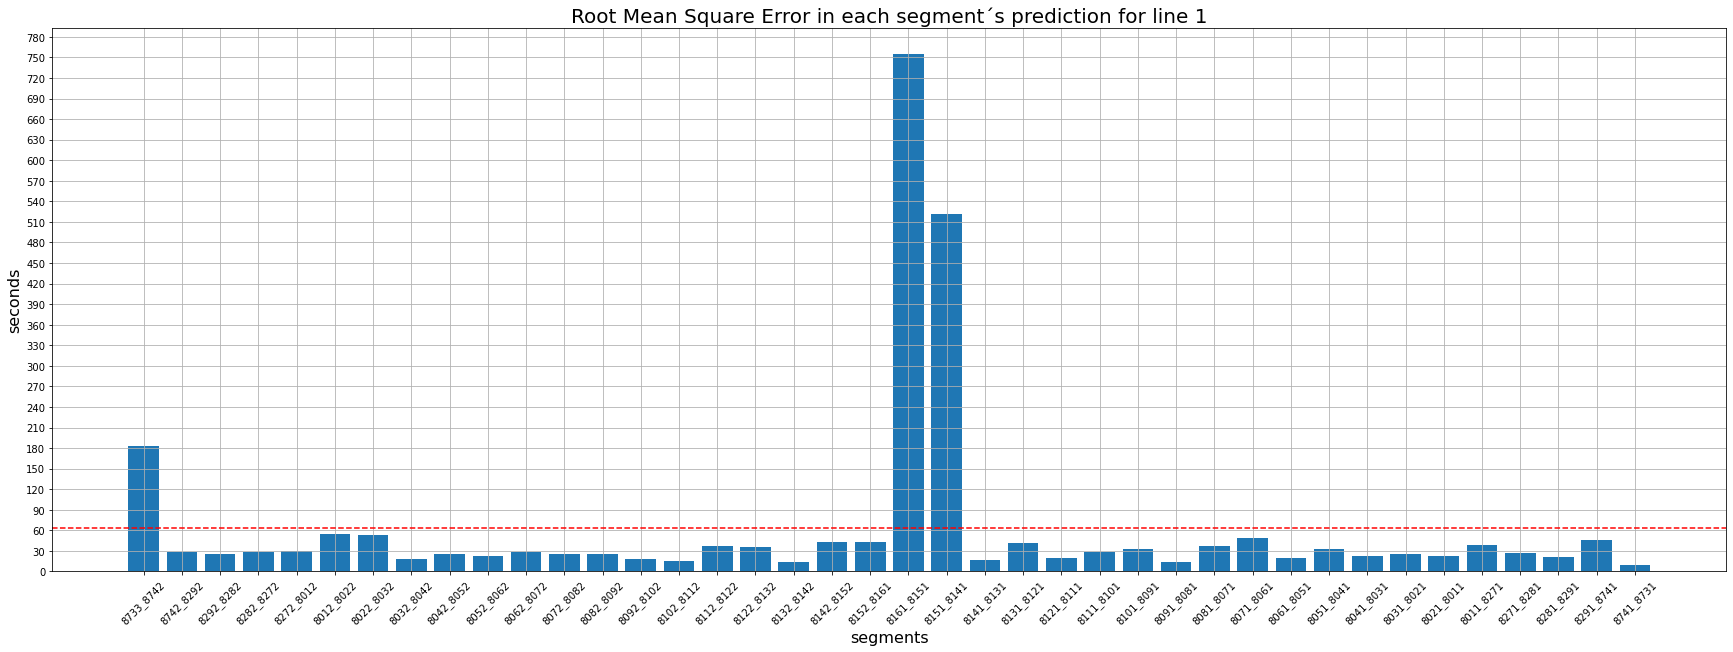

In [71]:
#----------------------------------------------------------------
# GRAPH
#----------------------------------------------------------------

# size:
plt.figure(figsize=(30,10))

# title:
plt.title('Root Mean Square Error in each segment´s prediction for line ' + str(line), fontsize=20)

# x axis:
# x values
x=[]
for index in range(len(all_testing_data_of_line)):
    x.append(index)
# x ticks
my_xticks = []
for segment in all_testing_data_of_line:
    my_xticks.append(segment)
plt.xticks(x, my_xticks, rotation='45')
# # x label
plt.xlabel("segments", fontsize=16)

# y axis:
# y values
y = all_rmse
# y ticks
plt.yticks(np.arange(0, max(all_rmse)+30, 30))
# y label
plt.ylabel("seconds", fontsize=16)

# mean
plt.axhline(sum(all_rmse)/len(all_rmse), color='r', alpha=1, linestyle='--')

# create plot
plt.bar(x, y)
# add grids to plot
plt.grid()
# show plot
plt.show()

#----------------------------------------------------------------

Text(0.5, 0, 'hours')

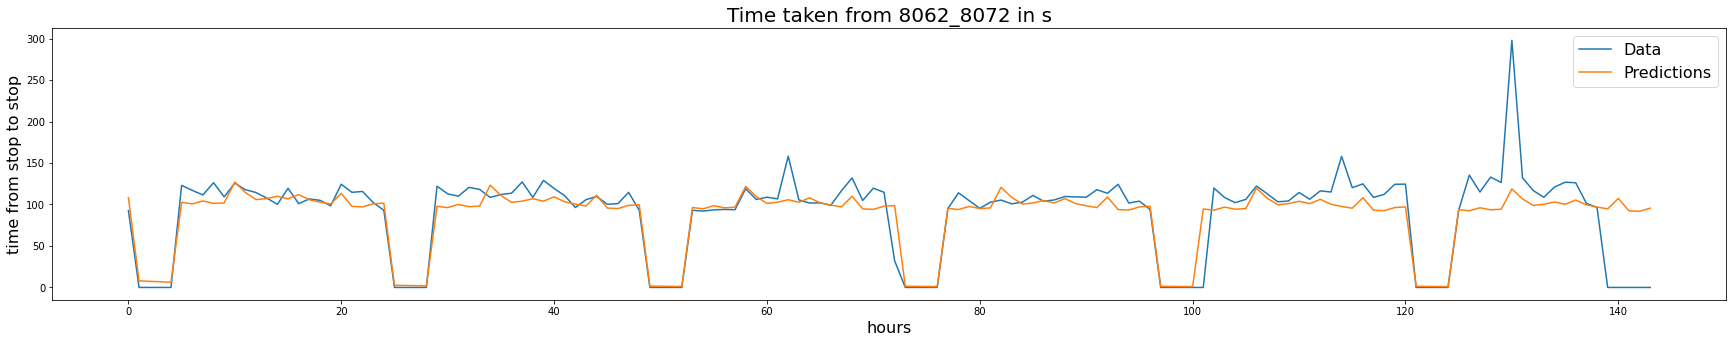

In [85]:
# Select an index to select a segment in the dictionaries
dict_index = 10

plt.figure(figsize=(30,5))

plt.plot(list(all_testing_data_of_line.values())[dict_index])
plt.plot(list(all_predictions_of_line.values())[dict_index])

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('Time taken from '+list(all_testing_data_of_line.keys())[dict_index]+' in s', fontsize=20)
plt.ylabel('time from stop to stop', fontsize=16)
plt.xlabel('hours', fontsize=16)



Now, let's create the daily tables with the predictions:

In [464]:
# Prediction tables:
prediction_tables = []
for i in range(total_days-training_days):
    prediction_tables.append(pd.DataFrame(columns = ['LineId', 'FromStop', 'ToStop'] + [str(i) for i in range(24)]))

# Populate the tables:
for table in range(len(prediction_tables)):
    for segment in all_predictions_of_line:
        row = pd.DataFrame([[line, segment.split("_", 1)[0], segment.split("_", 1)[1]]], columns=['LineId', 'FromStop', 'ToStop'])
        prediction_tables[table] = prediction_tables[table].append(row, ignore_index=True)
        for time in range(24):
             prediction_tables[table].loc[(prediction_tables[table]['FromStop']==segment.split("_", 1)[0]) & (prediction_tables[table]['ToStop']==segment.split("_", 1)[1]) & (prediction_tables[table]['LineId']==line), str(time)]= round(all_predictions_of_line[segment][time+24*table],2)

## Implementing the Model

Now that we have used SARIMA to creat a lookup table, we can use the data to start predicting arrival times given some starting point.

Let's try it out by getting the arrival time of a vehicle from line 1 to every stop given some start time. We will need to build a couple extra functions to make this process repeatable for any combination of line, date and time.

In [465]:
# INPUT 1: line number
line = 1

# INPUT 2: start time
start_time = '05:59:23'
start_time = pd.to_datetime(start_time, format='%H:%M:%S')

# INPUT 3: date (2021-09-16 to 21-09-21)
date = '2021-09-16'

So, given the line we defined before, let's create a function to get this information:

**get_line_segment_times**<br>
Given a line number, it gives the average time to get from stop to stop every hour.

*Input: line number*<br>
*Output: average time from stop to stop*

In [419]:
#get_line_segment_times

def get_line_segment_times(line, date, prediction_tables):

    # Get the predicted average times for the selected date
    if (date =='2021-09-16' ):
        all_lines_segment_times = prediction_tables[0]
    elif (date =='2021-09-17' ):
        all_lines_segment_times = prediction_tables[1]
    elif (date =='2021-09-18' ):
        all_lines_segment_times = prediction_tables[2]
    elif (date =='2021-09-19' ):
        all_lines_segment_times = prediction_tables[3]
    elif (date =='2021-09-20' ):
        all_lines_segment_times = prediction_tables[4]
    elif (date =='2021-09-20' ):
        all_lines_segment_times = prediction_tables[5]

    # Convert the times in seconds to format HH:MM:SS
    for i in range(24):
        all_lines_segment_times[str(i)]=pd.to_datetime(all_lines_segment_times[str(i)], unit='s').dt.strftime("%H:%M:%S")

    # Rename the headers for the time ranges
    all_lines_segment_times.rename(columns={
                                            "LineId": "lineId",
                                            "0": "00_01", 
                                            "1": "01_02",
                                            "2": "02_03",
                                            "3": "03_04",
                                            "4": "04_05",
                                            "5": "05_06",
                                            "6": "06_07",
                                            "7": "07_08",
                                            "8": "08_09",
                                            "9": "09_10",
                                            "10": "10_11",
                                            "11": "11_12",
                                            "12": "12_13",
                                            "13": "13_14",
                                            "14": "14_15",
                                            "15": "15_16",
                                            "16": "16_17",
                                            "17": "17_18",
                                            "18": "18_19",
                                            "19": "19_20",
                                            "20": "20_21",
                                            "21": "21_22",
                                            "22": "22_23",
                                            "23": "23_24"                                  
                                            }, inplace = True)

    # Take the segment times for the selected line
    line_segment_times = all_lines_segment_times[all_lines_segment_times['lineId']==line]

    return line_segment_times


In [420]:
line_segment_times = get_line_segment_times(line, date, prediction_tables)
line_segment_times

,lineId,FromStop,ToStop,00_01,01_02,02_03,03_04,04_05,05_06,06_07,...,14_15,15_16,16_17,17_18,18_19,19_20,20_21,21_22,22_23,23_24
0,1,8733,8742,00:00:52,00:00:00,00:00:00,00:00:00,00:00:00,00:01:15,00:01:17,...,00:01:21,00:01:00,00:00:27,00:01:20,00:01:01,00:02:04,00:02:55,00:00:00,00:02:03,00:07:59
1,1,8742,8292,00:00:57,00:00:00,00:00:00,00:00:00,00:00:00,00:01:03,00:01:29,...,00:01:44,00:01:40,00:01:40,00:02:06,00:01:49,00:01:38,00:01:37,00:01:40,00:01:34,00:01:24
2,1,8292,8282,00:00:45,00:00:00,00:00:00,00:00:00,00:00:00,00:00:37,00:00:55,...,00:01:04,00:01:07,00:01:06,00:01:10,00:01:05,00:01:05,00:01:01,00:00:59,00:01:02,00:00:56
3,1,8282,8272,00:00:58,00:00:00,00:00:00,00:00:00,00:00:00,00:00:55,00:01:34,...,00:01:37,00:01:40,00:01:36,00:01:55,00:01:39,00:01:39,00:01:39,00:01:35,00:01:35,00:01:29
4,1,8272,8012,00:01:03,00:00:00,00:00:00,00:00:00,00:00:00,00:00:41,00:01:10,...,00:01:04,00:01:06,00:01:11,00:01:09,00:01:10,00:01:04,00:01:04,00:01:06,00:01:06,00:01:08
5,1,8012,8022,00:00:58,00:00:00,00:00:00,00:00:00,00:00:00,00:00:50,00:01:07,...,00:01:17,00:01:18,00:01:19,00:01:17,00:01:14,00:01:10,00:01:14,00:01:14,00:01:13,00:01:08
6,1,8022,8032,00:00:53,00:00:00,00:00:00,00:00:00,00:00:00,00:01:02,00:01:06,...,00:01:05,00:01:04,00:01:05,00:01:09,00:01:05,00:01:11,00:01:07,00:01:01,00:01:04,00:01:08
7,1,8032,8042,00:00:54,00:00:00,00:00:00,00:00:00,00:00:00,00:00:48,00:01:02,...,00:01:17,00:01:11,00:01:05,00:01:07,00:01:12,00:01:08,00:01:04,00:01:04,00:01:03,00:01:00
8,1,8042,8052,00:00:49,00:00:00,00:00:00,00:00:00,00:00:00,00:00:39,00:00:47,...,00:00:50,00:00:55,00:00:56,00:00:57,00:00:55,00:00:52,00:00:56,00:00:52,00:00:49,00:00:56
9,1,8052,8062,00:01:10,00:00:00,00:00:00,00:00:00,00:00:00,00:00:52,00:01:13,...,00:01:35,00:01:19,00:01:24,00:01:21,00:01:39,00:01:19,00:01:38,00:01:18,00:01:17,00:01:15


We must consider here that this table includes the average time from stop to stop <u>in both directions</u>. So, the output of our predicting model should include two tables, each one containing the arrival times for one direction. The structure of the output tables should be:

In [429]:
output_structure= pd.DataFrame(columns=['lineId', 'departure_stop_id', 'departure_time', 'arrival_stop_Id', 'arrival_time'])
output_structure

,lineId,departure_stop_id,departure_time,arrival_stop_Id,arrival_time


Let's start making our model:

From the inputs, we have *start time*. This will be useful to know with which time range(s) from **line_segment_times** should we work with. To do this, we will create a function that takes the *start time* and outputs the corresponding time range's name from **line_segment_times*:

**get_time_range**<br>
Function to get the time range (two hours ranges) in which a given time is in.<br><br>
*Input: time*<br>
*Output: time range code*

In [422]:
# get_time_range: get

def get_time_range(start_time):
    if (pd.to_datetime('00:00:00', format='%H:%M:%S')<= start_time < pd.to_datetime('01:00:00', format='%H:%M:%S')):
        return '00_01'
    elif (pd.to_datetime('01:00:00', format='%H:%M:%S')<= start_time < pd.to_datetime('02:00:00', format='%H:%M:%S')):
        return '01_02'
    elif (pd.to_datetime('02:00:00', format='%H:%M:%S')<= start_time < pd.to_datetime('03:00:00', format='%H:%M:%S')):
        return '02_03'
    elif (pd.to_datetime('03:00:00', format='%H:%M:%S')<= start_time < pd.to_datetime('04:00:00', format='%H:%M:%S')):
        return '03_04'
    elif (pd.to_datetime('04:00:00', format='%H:%M:%S')<= start_time < pd.to_datetime('05:00:00', format='%H:%M:%S')):
        return '04_05'
    elif (pd.to_datetime('05:00:00', format='%H:%M:%S')<= start_time < pd.to_datetime('06:00:00', format='%H:%M:%S')):
        return '05_06'
    elif (pd.to_datetime('06:00:00', format='%H:%M:%S')<= start_time < pd.to_datetime('07:00:00', format='%H:%M:%S')):
        return '06_07'
    elif (pd.to_datetime('07:00:00', format='%H:%M:%S')<= start_time < pd.to_datetime('08:00:00', format='%H:%M:%S')):
        return '07_08'
    elif (pd.to_datetime('08:00:00', format='%H:%M:%S')<= start_time < pd.to_datetime('09:00:00', format='%H:%M:%S')):
        return '08_09'
    elif (pd.to_datetime('09:00:00', format='%H:%M:%S')<= start_time < pd.to_datetime('10:00:00', format='%H:%M:%S')):
        return '09_10'
    elif (pd.to_datetime('10:00:00', format='%H:%M:%S')<= start_time < pd.to_datetime('11:00:00', format='%H:%M:%S')):
        return '10_11'
    elif (pd.to_datetime('11:00:00', format='%H:%M:%S')<= start_time < pd.to_datetime('12:00:00', format='%H:%M:%S')):
        return '11_12'
    elif (pd.to_datetime('12:00:00', format='%H:%M:%S')<= start_time < pd.to_datetime('13:00:00', format='%H:%M:%S')):
        return '12_13'
    elif (pd.to_datetime('13:00:00', format='%H:%M:%S')<= start_time < pd.to_datetime('14:00:00', format='%H:%M:%S')):
        return '13_14'
    elif (pd.to_datetime('14:00:00', format='%H:%M:%S')<= start_time < pd.to_datetime('15:00:00', format='%H:%M:%S')):
        return '14_15'
    elif (pd.to_datetime('15:00:00', format='%H:%M:%S')<= start_time < pd.to_datetime('16:00:00', format='%H:%M:%S')):
        return '15_16'
    elif (pd.to_datetime('16:00:00', format='%H:%M:%S')<= start_time < pd.to_datetime('17:00:00', format='%H:%M:%S')):
        return '16_17'
    elif (pd.to_datetime('17:00:00', format='%H:%M:%S')<= start_time < pd.to_datetime('18:00:00', format='%H:%M:%S')):
        return '17_18'
    elif (pd.to_datetime('18:00:00', format='%H:%M:%S')<= start_time < pd.to_datetime('19:00:00', format='%H:%M:%S')):
        return '18_19'
    elif (pd.to_datetime('19:00:00', format='%H:%M:%S')<= start_time < pd.to_datetime('20:00:00', format='%H:%M:%S')):
        return '19_20'
    elif (pd.to_datetime('20:00:00', format='%H:%M:%S')<= start_time < pd.to_datetime('21:00:00', format='%H:%M:%S')):
        return '20_21'
    elif (pd.to_datetime('21:00:00', format='%H:%M:%S')<= start_time < pd.to_datetime('22:00:00', format='%H:%M:%S')):
        return '21_22'
    elif (pd.to_datetime('22:00:00', format='%H:%M:%S')<= start_time < pd.to_datetime('23:00:00', format='%H:%M:%S')):
        return '22_23'
    elif (pd.to_datetime('23:00:00', format='%H:%M:%S')<= start_time < pd.to_datetime('24:00:00', format='%H:%M:%S')):
        return '23_24'
         
    

Let´s get the time range in which the starting time is in:

In [444]:
time_range = get_time_range(start_time)
time_range

'05_06'

Now that we got the time range of the vehicle's starting time, let´s calculate the arrival time to the very next stop. For this we have to consider the two possible *departure_stop_id*'s. From assignment 1, we can get the series of stops that a line's sequentially vehicle goes trough. So, let's make a function that gives the sequence of stops given a line:

**get_sequence_stops_by_line**<br>
Given a line number, it gives the two sequences of stops, each for one direction

*Input: line number*<br>
*Output: list with the two sequences of stops (direction 1 and direction 2)*

In [445]:
# get_sequence_stops_by_line

def get_sequence_stops_by_line(line):

    # Get a table indicating all the stops sequences for all the lines
    stops_sequences_by_lines = pd.read_csv(r'./processed_data/line_stops.csv')
    
    # Convert lineId to integer
    stops_sequences_by_lines['lineId'] = stops_sequences_by_lines['lineId'].map(lambda x: int(str(x)[:-1]))

    # Get the number of stops for the selected line travelling in direction 1
    number_of_stops_by_line_dir1 = stops_sequences_by_lines[(stops_sequences_by_lines['lineId']==line ) & (stops_sequences_by_lines['direction'] == 1)]['order'].max()

    # Get the number of stops for the selected line travelling in direction 2
    number_of_stops_by_line_dir2 = stops_sequences_by_lines[(stops_sequences_by_lines['lineId']==line ) & (stops_sequences_by_lines['direction'] == 2)]['order'].max()


    # Make two list with the stops sequence in each direction
    stops_sequences_by_line = []
    stops_sequence_by_line_dir1 = []
    stops_sequence_by_line_dir2 = []

    # Direction 1
    for i in range(number_of_stops_by_line_dir1):
        stops_sequence_by_line_dir1.append(stops_sequences_by_lines[(stops_sequences_by_lines['lineId']==line) & (stops_sequences_by_lines['direction'] == 1) & (stops_sequences_by_lines['order'] ==( i+1))]['stop_id_int'].values[0])
    stops_sequences_by_line.append(stops_sequence_by_line_dir1)

    # Direction 2
    for i in range(number_of_stops_by_line_dir2):
        stops_sequence_by_line_dir2.append(stops_sequences_by_lines[(stops_sequences_by_lines['lineId']==line) & (stops_sequences_by_lines['direction'] == 2) & (stops_sequences_by_lines['order'] ==( i+1))]['stop_id_int'].values[0])
    stops_sequences_by_line.append(stops_sequence_by_line_dir2)

    return stops_sequences_by_line

Let's get the two sequences:

In [447]:
stops_sequence_by_line = get_sequence_stops_by_line(line)

We can say that our possible *departure_stop_id*'s  are:

In [448]:
departure_stop_id_dir1 = stops_sequence_by_line[0][0]
departure_stop_id_dir2 = stops_sequence_by_line[1][0]

print('The departure stop in direction 1 is: '+str(departure_stop_id_dir1))
print('The departure stop in direction 2 is: '+str(departure_stop_id_dir2))

The departure stop in direction 1 is: 8733
The departure stop in direction 2 is: 8161


In order to get what is the next stop given a departure stop and a current stop, we will make a function:

**get_next_stop**<br>
Get the next stop given a departure stop (to know the direction) and the current stop<br>

*Input: departure stop id, current stop id, stop ids sequence* <br>
*Output: next stop id*

In [449]:
def get_next_stop(departure_stop_id, current_stop_id, stop_ids_sequence):
    if (departure_stop_id == stop_ids_sequence[0][0]):
        next_stop = stop_ids_sequence[0][stop_ids_sequence[0].index(current_stop_id)+1]
    elif (departure_stop_id == stop_ids_sequence[1][0]):
        next_stop = stop_ids_sequence[1][stop_ids_sequence[1].index(current_stop_id)+1]
    return next_stop

In [454]:
line_segment_times.head()

,lineId,FromStop,ToStop,00_01,01_02,02_03,03_04,04_05,05_06,06_07,...,14_15,15_16,16_17,17_18,18_19,19_20,20_21,21_22,22_23,23_24
0,1,8733,8742,00:00:52,00:00:00,00:00:00,00:00:00,00:00:00,00:01:15,00:01:17,...,00:01:21,00:01:00,00:00:27,00:01:20,00:01:01,00:02:04,00:02:55,00:00:00,00:02:03,00:07:59
1,1,8742,8292,00:00:57,00:00:00,00:00:00,00:00:00,00:00:00,00:01:03,00:01:29,...,00:01:44,00:01:40,00:01:40,00:02:06,00:01:49,00:01:38,00:01:37,00:01:40,00:01:34,00:01:24
2,1,8292,8282,00:00:45,00:00:00,00:00:00,00:00:00,00:00:00,00:00:37,00:00:55,...,00:01:04,00:01:07,00:01:06,00:01:10,00:01:05,00:01:05,00:01:01,00:00:59,00:01:02,00:00:56
3,1,8282,8272,00:00:58,00:00:00,00:00:00,00:00:00,00:00:00,00:00:55,00:01:34,...,00:01:37,00:01:40,00:01:36,00:01:55,00:01:39,00:01:39,00:01:39,00:01:35,00:01:35,00:01:29
4,1,8272,8012,00:01:03,00:00:00,00:00:00,00:00:00,00:00:00,00:00:41,00:01:10,...,00:01:04,00:01:06,00:01:11,00:01:09,00:01:10,00:01:04,00:01:04,00:01:06,00:01:06,00:01:08


Let's calculate the arrival time to the next stop assuming that the vehicle is leaving from *departure_stop_id_0*

In [458]:
# Current stop_id
current_stop = departure_stop_id_dir1

# Next stop_id
next_stop = get_next_stop(departure_stop_id_dir1, current_stop, stops_sequence_by_line )

# Average time that takes to go to the next stop at a given specific time range
avg_time = line_segment_times[(line_segment_times['FromStop'] == str(current_stop)) & (line_segment_times['ToStop'] == str(next_stop)) ][time_range].values[0]

avg_time


'00:01:15'

Let´s now get the time of arrival to that next stop:

In [459]:
avg_time = pd.to_datetime(avg_time, format='%H:%M:%S')
arrival_time = (start_time - pd.to_datetime('00:00:00', format='%H:%M:%S') + avg_time).time().strftime('%H:%M:%S')
arrival_time

'06:00:38'

This process has to be done for every segment (stop to stop) of the vehicle trip for both directions. So, let's make a function that does this.

**forecasting_arrival_times**
Function to get the arrival times of a line's vehicle accross all it's stops for both directions.<br>

*Input: line and start time*<br>
*Output: a list with two tables with the arrival (one table for every direction)*

In [466]:
def forecasting_arrival_times_by_line(line, start_time, date, prediction_tables):
    
    # Get the average times per segments (stop to stop)
    line_segment_times = get_line_segment_times(line, date, prediction_tables)

    # Get the stops sequence for the line
    stops_sequence_by_line = get_sequence_stops_by_line(line)

    # Get the stops sequence in direction 1
    stops_sequence_by_line_dir1 = stops_sequence_by_line[0]

    # Get the stops sequence in direction 2
    stops_sequence_by_line_dir2 = stops_sequence_by_line[1]

    # Get the two possible departure stops for the line:
    departure_stop_id_dir1 = stops_sequence_by_line[0][0]
    departure_stop_id_dir2 = stops_sequence_by_line[1][0]

    # Departure time
    departure_time = start_time

    # Populate the table:
    
    # assuming departure_stop_id_dir1:
    # Data to output
    output_data = []
    for i in range(len(stops_sequence_by_line_dir1)-1):

        # Stops sequence
        stops_sequence = stops_sequence_by_line
      
        # Current stop
        current_stop =stops_sequence[0][i]
        
        # Next stop
        next_stop = get_next_stop(departure_stop_id_dir1, current_stop, stops_sequence_by_line )
        
        # Get the time range of the departure time at current stop
        time_range = get_time_range(departure_time)
        
        # Average time to get to next stop
        avg_time = pd.to_datetime(line_segment_times[(line_segment_times['FromStop'] == str(current_stop)) & (line_segment_times['ToStop'] == str(next_stop))][time_range].values[0], format='%H:%M:%S')

        # Arrival time
        arrival_time = (departure_time - pd.to_datetime('00:00:00', format='%H:%M:%S') + avg_time).time().strftime('%H:%M:%S')

        # Add the data to the data list
        output_data.append({'lineId': line, 'departure_stop_id' : current_stop, 'departure_time' : departure_time.strftime('%H:%M:%S'), 'arrival_stop_Id' : next_stop, 'arrival_time' :  arrival_time })

        # Update next departure time
        departure_time = pd.to_datetime(arrival_time, format='%H:%M:%S')

        output_table_1 = pd.DataFrame(output_data)
    
    # Set again departure time to analyze the other direction
    departure_time = start_time

    # assuming departure_stop_id_dir2:
    # Data to output
    output_data = []
    
    for i in range(len(stops_sequence_by_line_dir2)-1):

        # Stops sequence
        stops_sequence = stops_sequence_by_line
      
        # Current stop
        current_stop = stops_sequence[1][i]

        # Next stop
        next_stop = get_next_stop(departure_stop_id_dir2, current_stop, stops_sequence_by_line )
        
        # Get the time range of the departure time at current stop
        time_range = get_time_range(departure_time)
        
        # Average time to get to next stop
        avg_time = pd.to_datetime(line_segment_times[(line_segment_times['FromStop'] == str(current_stop)) & (line_segment_times['ToStop'] == str(next_stop)) ][time_range].values[0], format='%H:%M:%S')

        # Arrival time
        arrival_time = (departure_time - pd.to_datetime('00:00:00', format='%H:%M:%S') + avg_time).time().strftime('%H:%M:%S')

        # Add the data to the data list
        output_data.append({'lineId': line, 'departure_stop_id' : current_stop, 'departure_time' : departure_time.strftime('%H:%M:%S'), 'arrival_stop_Id' : next_stop, 'arrival_time' :  arrival_time })

        # Update next departure time (here we may add an average delay that buses have at stations)
        departure_time = pd.to_datetime(arrival_time, format='%H:%M:%S')

        output_table_2 = pd.DataFrame(output_data)

    output = [output_table_1, output_table_2 ]


    return output


Let's use the function with the two inputs (line and start time) we defined at the beginning:

In [467]:
arrival_times = forecasting_arrival_times_by_line(line, start_time, date, prediction_tables)

The arrival times for the line travelling in direction 1 would be:

In [468]:
arrival_times[0]

,lineId,departure_stop_id,departure_time,arrival_stop_Id,arrival_time
0,1,8733,05:59:23,8742,06:00:38
1,1,8742,06:00:38,8292,06:02:07
2,1,8292,06:02:07,8282,06:03:02
3,1,8282,06:03:02,8272,06:04:36
4,1,8272,06:04:36,8012,06:05:46
5,1,8012,06:05:46,8022,06:06:53
6,1,8022,06:06:53,8032,06:07:59
7,1,8032,06:07:59,8042,06:09:01
8,1,8042,06:09:01,8052,06:09:48
9,1,8052,06:09:48,8062,06:11:01


The arrival times for the line travelling in direction 2 would be:

In [469]:
arrival_times[1]

,lineId,departure_stop_id,departure_time,arrival_stop_Id,arrival_time
0,1,8161,05:59:23,8151,06:03:30
1,1,8151,06:03:30,8141,06:04:04
2,1,8141,06:04:04,8131,06:04:46
3,1,8131,06:04:46,8121,06:06:56
4,1,8121,06:06:56,8111,06:07:43
5,1,8111,06:07:43,8101,06:09:30
6,1,8101,06:09:30,8091,06:10:27
7,1,8091,06:10:27,8081,06:11:14
8,1,8081,06:11:14,8071,06:13:00
9,1,8071,06:13:00,8061,06:14:46


An additional function can be created to get as a result only one arrival's table (one direction). For that, we would have to specify the departure_stop_id:

**forecasting_arrival_times_by_line_and_departure**<br>
Gives a table with the line's arrival times at every stop given a departure time and departure stop

*Input: line, start time, departure stop id*<br>
*Output: Table with arrival times at every stop*


In [ ]:
def forecasting_arrival_times_by_line_and_departure(line, start_time, departure_stop_id):
    arrival_times_both_directions = forecasting_arrival_times_by_line(line, start_time)
    # If the departure stop corresponds to the direction 1
    if (arrival_times_both_directions[0]['departure_stop_id'].values[0]==departure_stop_id):
        output =  arrival_times_both_directions[0]

    # If the departure stop corresponds to the direction 2
    elif (arrival_times_both_directions[1]['departure_stop_id'].values[0]==departure_stop_id):
        output =  arrival_times_both_directions[1]

    else:
    # If the departure stops does not correspond to any departure stop from the line
        output = print('The departure stop provided does not correspond to any of the two possible departures stops from line '+str(line))
    return output

In [ ]:
forecasting_arrival_times_by_line_and_departure(line, start_time, 8161)

,lineId,departure_stop_id,departure_time,arrival_stop_Id,arrival_time
0,1,8161,05:59:23,8151,06:22:01
1,1,8151,06:22:01,8141,06:23:09
2,1,8141,06:23:09,8131,06:24:02
3,1,8131,06:24:02,8121,06:26:12
4,1,8121,06:26:12,8111,06:27:06
5,1,8111,06:27:06,8101,06:28:58
6,1,8101,06:28:58,8091,06:29:57
7,1,8091,06:29:57,8081,06:30:51
8,1,8081,06:30:51,8071,06:32:47
9,1,8071,06:32:47,8061,06:34:43


## How did we do?

We were able to use our time between stops to predict the arrival time at every station on a line. A SARIMA time series was used to create a lookup table that can be applied for any stop and any line. This allows for fast processing as the computationally expensive operations can all be completed once and reused. This approach would allow this model to easily be applied to a live data stream and updated constantly given some input.